In [28]:
# Install dependencies (only run if needed)
!pip install GEOparse pandas matplotlib seaborn scipy numpy statsmodels gseapy

In [29]:
# Imports
# ----------------------------
import GEOparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
import gseapy as gp


In [30]:
# ----------------------------
# Step 1: Download GEO dataset
# ----------------------------
gse_id = "GSE89076"   # <-- Change to any GEO Series ID
gse = GEOparse.get_GEO(geo=gse_id, destdir=".")

print(f"Dataset: {gse_id}")
print(f"Title: {gse.metadata['title'][0]}")
print(f"Samples: {len(gse.gsms)}")

25-Sep-2025 17:13:59 DEBUG utils - Directory . already exists. Skipping.
DEBUG:GEOparse:Directory . already exists. Skipping.
25-Sep-2025 17:13:59 INFO GEOparse - File already exist: using local version.
INFO:GEOparse:File already exist: using local version.
25-Sep-2025 17:13:59 INFO GEOparse - Parsing ./GSE89076_family.soft.gz: 
INFO:GEOparse:Parsing ./GSE89076_family.soft.gz: 
25-Sep-2025 17:13:59 DEBUG GEOparse - DATABASE: GeoMiame
DEBUG:GEOparse:DATABASE: GeoMiame
25-Sep-2025 17:13:59 DEBUG GEOparse - SERIES: GSE89076
DEBUG:GEOparse:SERIES: GSE89076
25-Sep-2025 17:13:59 DEBUG GEOparse - PLATFORM: GPL16699
DEBUG:GEOparse:PLATFORM: GPL16699
25-Sep-2025 17:14:01 DEBUG GEOparse - SAMPLE: GSM2358437
DEBUG:GEOparse:SAMPLE: GSM2358437
25-Sep-2025 17:14:01 DEBUG GEOparse - SAMPLE: GSM2358438
DEBUG:GEOparse:SAMPLE: GSM2358438
25-Sep-2025 17:14:02 DEBUG GEOparse - SAMPLE: GSM2358439
DEBUG:GEOparse:SAMPLE: GSM2358439
25-Sep-2025 17:14:02 DEBUG GEOparse - SAMPLE: GSM2358440
DEBUG:GEOparse:SAMP

Dataset: GSE89076
Title: DNA microarray analysis of human colorectal cancer specimens
Samples: 80


In [31]:
# ----------------------------
# Step 2: Build Expression Matrix
# ----------------------------
dfs = []
for gsm_name, gsm in gse.gsms.items():
    if gsm.table is not None and "VALUE" in gsm.table.columns:
        df = gsm.table[["ID_REF", "VALUE"]].copy()
        df.rename(columns={"VALUE": gsm_name}, inplace=True)
        dfs.append(df)

expr_df = dfs[0]
for df in dfs[1:]:
    expr_df = expr_df.merge(df, on="ID_REF")

expr_df.set_index("ID_REF", inplace=True)

print("Expression Matrix Shape:", expr_df.shape)

# Save raw expression matrix
expr_df.to_csv("expression.csv")
print("✅ Saved: expression.csv")


Expression Matrix Shape: (58717, 80)
✅ Saved: expression.csv


In [32]:
# Step 3: Differential Expression Analysis
# ----------------------------
n = len(expr_df.columns)
control = expr_df.iloc[:, :n//2]
treated = expr_df.iloc[:, n//2:]

results = []
for gene in expr_df.index:
    ctrl_vals = control.loc[gene].dropna()
    trt_vals = treated.loc[gene].dropna()
    if len(ctrl_vals) > 1 and len(trt_vals) > 1:
        t_stat, pval = ttest_ind(ctrl_vals, trt_vals, nan_policy="omit")
        logFC = trt_vals.mean() - ctrl_vals.mean()
        AveExpr = expr_df.loc[gene].mean()
        results.append([gene, logFC, AveExpr, t_stat, pval])
    else:
        results.append([gene, np.nan, np.nan, np.nan, np.nan])

deg_df = pd.DataFrame(results, columns=["probid", "logFC", "AveExpr", "t", "pval"])

# Adjust p-values (FDR)
deg_df["adj.P.Val"] = multipletests(deg_df["pval"], method="fdr_bh")[1]
# Approximate B-statistic (log-odds of being DE)
deg_df["B"] = np.log((1 - deg_df["adj.P.Val"]) / (deg_df["adj.P.Val"] + 1e-10))

deg_df.to_csv("DEG.csv", index=False)
print("✅ Saved: DEG.csv")

/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning:

divide by zero encountered in log



✅ Saved: DEG.csv


In [33]:
# ----------------------------
# Step 4: Filter Significant DEGs
# ----------------------------
sig_df = deg_df[(deg_df["adj.P.Val"] < 0.1) & (abs(deg_df["logFC"]) > 1.5)]
sig_df.to_csv("Significant.csv", index=False)
print(f"✅ Saved: Significant.csv ({sig_df.shape[0]} significant genes)")


✅ Saved: Significant.csv (1521 significant genes)


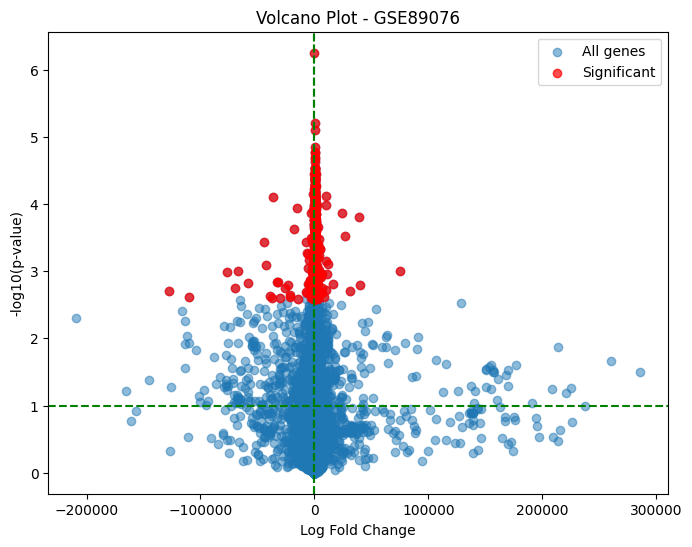

✅ Saved: volcano_plot.png


In [34]:
# ----------------------------
# Step 5: Volcano Plot
# ----------------------------
deg_df["-log10p"] = -np.log10(deg_df["pval"] + 1e-300)

plt.figure(figsize=(8,6))
plt.scatter(deg_df["logFC"], deg_df["-log10p"], alpha=0.5, label="All genes")
plt.scatter(sig_df["logFC"], -np.log10(sig_df["pval"]), color="red", alpha=0.7, label="Significant")

plt.axhline(-np.log10(0.1), color="green", linestyle="--")
plt.axvline(-1, color="green", linestyle="--")
plt.axvline(1, color="green", linestyle="--")
plt.xlabel("Log Fold Change")
plt.ylabel("-log10(p-value)")
plt.title(f"Volcano Plot - {gse_id}")
plt.legend()
plt.savefig("volcano_plot.png", dpi=300)
plt.show()
print("✅ Saved: volcano_plot.png")

In [35]:
enr = gp.enrichr(
    gene_list=sig_genes,
    gene_sets=['GO_Biological_Process_2021', 'KEGG_2021_Human'],
    organism='Human',
    outdir=None,
    cutoff=1.0,   # keep everything
    verbose=True
)

if hasattr(enr, "res2d") and not enr.res2d.empty:
    print("✅ Found enrichment terms")
    display(enr.res2d.head(20))  # show top 20
else:
    print("⚠️ No enrichment terms found, even with cutoff=1.0")



2025-09-25 17:16:54,627 [INFO] Run: GO_Biological_Process_2021 
2025-09-25 17:16:57,696 [INFO] Run: KEGG_2021_Human 
2025-09-25 17:16:59,601 [INFO] Done.


✅ Found enrichment terms


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2021_Human,Non-homologous end-joining,2/13,0.187088,0.999996,0,0,2.791995,4.679873,XRCC6;POLL
1,KEGG_2021_Human,Staphylococcus aureus infection,7/95,0.362741,0.999996,0,0,1.221484,1.238665,IL10;KRT33A;KRT18;KRT26;C3AR1;KRT32;FCAR
2,KEGG_2021_Human,Synthesis and degradation of ketone bodies,1/10,0.468299,0.999996,0,0,1.705006,1.293500,HMGCLL1
3,KEGG_2021_Human,Morphine addiction,6/91,0.486160,0.999996,0,0,1.083222,0.781240,GABRB1;GRK5;GNB2;GRK6;GNG8;PDE8B
4,KEGG_2021_Human,Basal cell carcinoma,4/63,0.543556,0.999996,0,0,1.040122,0.634081,WNT10B;APC;PTCH2;WNT1
5,KEGG_2021_Human,Hematopoietic cell lineage,6/99,0.569460,0.999996,0,0,0.989618,0.557222,CSF3R;CSF1;THPO;ITGA2B;GP1BA;IL9R
6,KEGG_2021_Human,Asthma,2/31,0.573710,0.999996,0,0,1.058017,0.587868,IL10;FCER1G
7,KEGG_2021_Human,Circadian rhythm,2/31,0.573710,0.999996,0,0,1.058017,0.587868,CSNK1E;PRKAB1
8,KEGG_2021_Human,Viral protein interaction with cytokine and cy...,6/100,0.579411,0.999996,0,0,0.979038,0.534303,IL10;IL18RAP;XCR1;CSF1;TNFSF10;TNFRSF14
9,KEGG_2021_Human,Fc epsilon RI signaling pathway,4/68,0.604692,0.999996,0,0,0.958607,0.482214,MAP2K3;FCER1G;RAC2;VAV2


In [36]:
print(f"Number of genes in list: {len(sig_genes)}")
print(sig_genes[:10])  # preview first 10


Number of genes in list: 1294
['SEPT8', 'SEP15', 'SEP15', 'AAK1', 'AAMP', 'ABHD11', 'ABHD11', 'ACBD7', 'ACER2', 'ACR']


In [37]:
# =============================
# Functional Enrichment + Visualization
# =============================

if not sig_df.empty:
    print("Running functional enrichment...")

    enr = gp.enrichr(
        gene_list=sig_df['probid'].astype(str).tolist(),  # fallback if no mapping
        gene_sets=['GO_Biological_Process_2021', 'KEGG_2021_Human'],
        organism='Human',   # adjust if dataset is not human
        outdir=None,        # don’t auto-save files
        cutoff=1.0,         # return all results, we'll filter manually
        verbose=True
    )

    # Access full results table
    if hasattr(enr, "res2d") and not enr.res2d.empty:
        enrichment_df = enr.res2d.copy()
        enrichment_df.to_csv("enrichment_results.csv", index=False)
        print(f"✅ Saved: enrichment_results.csv ({enrichment_df.shape[0]} terms)")

        # Pick top 10 by Adjusted P-value
        top_n = 10
        top_terms = enrichment_df.sort_values("Adjusted P-value").head(top_n)

        # Visualization
        plt.figure(figsize=(10, 6))
        sns.barplot(
            x="Adjusted P-value",
            y="Term",
            data=top_terms.sort_values("Adjusted P-value", ascending=False),
            palette="viridis"
        )
        plt.title(f"Top {top_n} Enriched Terms")
        plt.xlabel("Adjusted P-value")
        plt.ylabel("Enriched Term")
        plt.tight_layout()
        plt.savefig("enrichment_barplot.png", dpi=300)
        plt.show()
        print("✅ Saved: enrichment_barplot.png")

    else:
        print("⚠️ No enrichment terms found — check gene list or organism setting.")
else:
    print("⚠️ No significant DEGs available for enrichment analysis.")


Running functional enrichment...


2025-09-25 17:16:59,887 [INFO] Run: GO_Biological_Process_2021 
2025-09-25 17:17:03,896 [INFO] Run: KEGG_2021_Human 
2025-09-25 17:17:06,146 [INFO] Done.


⚠️ No enrichment terms found — check gene list or organism setting.


25-Sep-2025 17:17:06 DEBUG utils - Directory . already exists. Skipping.
DEBUG:GEOparse:Directory . already exists. Skipping.
25-Sep-2025 17:17:06 INFO GEOparse - File already exist: using local version.
INFO:GEOparse:File already exist: using local version.
25-Sep-2025 17:17:06 INFO GEOparse - Parsing ./GPL16699.txt: 
INFO:GEOparse:Parsing ./GPL16699.txt: 
25-Sep-2025 17:17:06 DEBUG GEOparse - PLATFORM: GPL16699
DEBUG:GEOparse:PLATFORM: GPL16699


Preparing gene list for enrichment...
Annotation columns: ['ID', 'COL', 'ROW', 'NAME', 'SPOT_ID', 'CONTROL_TYPE', 'REFSEQ', 'GB_ACC', 'LOCUSLINK_ID', 'GENE_SYMBOL'] ...
Using annotation column: GENE_SYMBOL
✅ Mapped 1294 probes to gene symbols.
Running functional enrichment...


/tmp/ipython-input-2830432454.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

2025-09-25 17:17:07,876 [INFO] Run: GO_Biological_Process_2021 
2025-09-25 17:17:09,959 [INFO] Run: KEGG_2021_Human 
2025-09-25 17:17:11,877 [INFO] Done.
/tmp/ipython-input-2830432454.py:67: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




✅ Saved: enrichment_results.csv (230 terms)


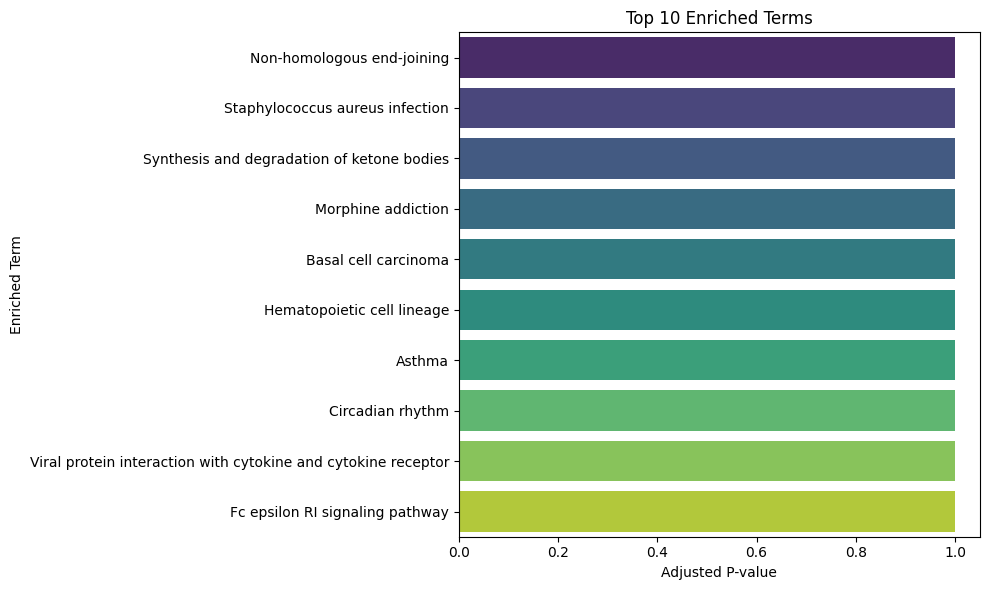

✅ Saved: enrichment_barplot.png


In [38]:
# =============================
# Functional Enrichment with Probe → Gene Symbol Mapping
# =============================

if not sig_df.empty:
    print("Preparing gene list for enrichment...")

    # Step 1: Try to map probes to gene symbols
    sig_genes = []
    try:
        # Get first platform ID (usually only one)
        platform_id = list(gse.gpls.keys())[0]
        platform_geo = GEOparse.get_GEO(geo=platform_id, destdir=".")
        platform_annot = platform_geo.table

        # Inspect available columns
        print(f"Annotation columns: {platform_annot.columns[:10].tolist()} ...")

        # Common annotation column names across GEO
        candidate_cols = [c for c in platform_annot.columns if "symbol" in c.lower()]

        if "ID" in platform_annot.columns and candidate_cols:
            gene_col = candidate_cols[0]  # pick first column that looks like Gene Symbol
            print(f"Using annotation column: {gene_col}")

            # Build mapping dictionary
            probe_to_symbol = platform_annot.set_index("ID")[gene_col].dropna().to_dict()

            # Map probes to symbols
            sig_df["Gene_Symbol"] = sig_df["probid"].map(probe_to_symbol)
            sig_genes = sig_df["Gene_Symbol"].dropna().astype(str).tolist()

            print(f"✅ Mapped {len(sig_genes)} probes to gene symbols.")
        else:
            print("⚠️ No gene symbol column found, using probe IDs instead.")
            sig_genes = sig_df["probid"].dropna().astype(str).tolist()

    except Exception as e:
        print(f"⚠️ Mapping failed: {e}")
        sig_genes = sig_df["probid"].dropna().astype(str).tolist()

    # Step 2: Run enrichment
    if sig_genes:
        print("Running functional enrichment...")

        enr = gp.enrichr(
            gene_list=sig_genes,
            gene_sets=["GO_Biological_Process_2021", "KEGG_2021_Human"],
            organism="Human",   # adjust if not Human
            outdir=None,
            cutoff=1.0,         # return all results
            verbose=True
        )

        # Step 3: Process results
        if hasattr(enr, "res2d") and not enr.res2d.empty:
            enrichment_df = enr.res2d.copy()
            enrichment_df.to_csv("enrichment_results.csv", index=False)
            print(f"✅ Saved: enrichment_results.csv ({enrichment_df.shape[0]} terms)")

            # Top enriched terms
            top_n = 10
            top_terms = enrichment_df.sort_values("Adjusted P-value").head(top_n)

            # Visualization
            plt.figure(figsize=(10, 6))
            sns.barplot(
                x="Adjusted P-value",
                y="Term",
                data=top_terms.sort_values("Adjusted P-value", ascending=False),
                palette="viridis"
            )
            plt.title(f"Top {top_n} Enriched Terms")
            plt.xlabel("Adjusted P-value")
            plt.ylabel("Enriched Term")
            plt.tight_layout()
            plt.savefig("enrichment_barplot.png", dpi=300)
            plt.show()
            print("✅ Saved: enrichment_barplot.png")

        else:
            print("⚠️ No enrichment terms found. Try different gene sets or organism.")

    else:
        print("⚠️ No valid genes for enrichment analysis.")
else:
    print("⚠️ No significant DEGs available for enrichment analysis.")


25-Sep-2025 17:17:12 DEBUG utils - Directory . already exists. Skipping.
DEBUG:GEOparse:Directory . already exists. Skipping.
25-Sep-2025 17:17:12 INFO GEOparse - File already exist: using local version.
INFO:GEOparse:File already exist: using local version.
25-Sep-2025 17:17:12 INFO GEOparse - Parsing ./GPL16699.txt: 
INFO:GEOparse:Parsing ./GPL16699.txt: 
25-Sep-2025 17:17:12 DEBUG GEOparse - PLATFORM: GPL16699
DEBUG:GEOparse:PLATFORM: GPL16699


Preparing gene list for enrichment...
Detected organism: Human
Using Enrichr organism: Human
Using annotation column: GENE_SYMBOL
✅ Mapped 1294 probes to gene symbols.
Running functional enrichment...


/tmp/ipython-input-1041955096.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

2025-09-25 17:17:14,205 [INFO] Run: GO_Biological_Process_2021 
2025-09-25 17:17:16,244 [INFO] Run: KEGG_2021_Human 
2025-09-25 17:17:18,214 [INFO] Done.
/tmp/ipython-input-1041955096.py:90: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




✅ Saved: enrichment_results.csv (230 terms)


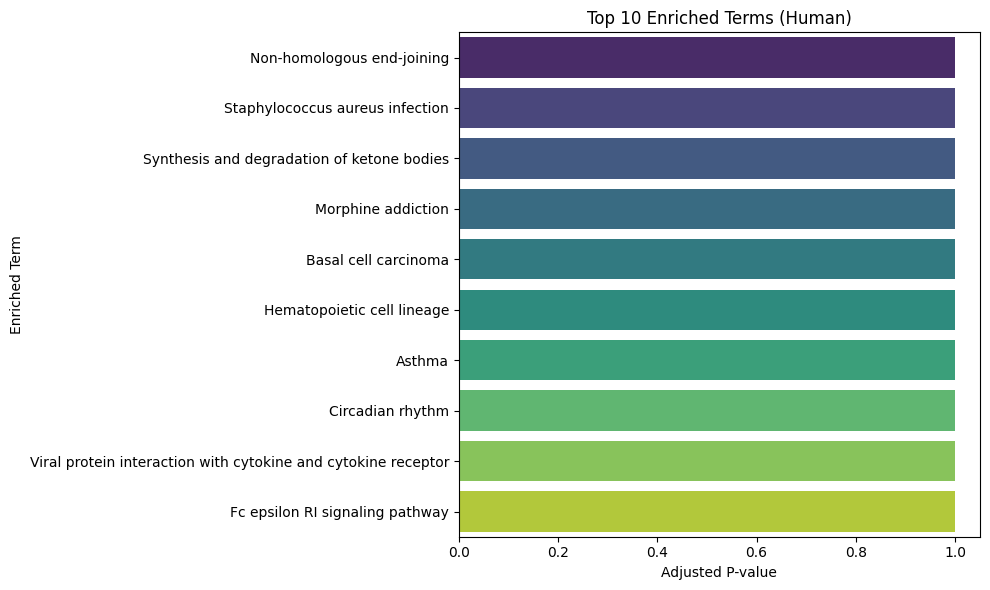

✅ Saved: enrichment_barplot.png


In [39]:
# =============================
# Functional Enrichment with Probe → Gene Symbol Mapping + Auto Organism Detection
# =============================

if not sig_df.empty:
    print("Preparing gene list for enrichment...")

    # ----------------------------
    # Step 1: Detect organism
    # ----------------------------
    try:
        if "organism_ch1" in gse.metadata:
            organism_raw = gse.metadata["organism_ch1"][0]
        else:
            organism_raw = "Human"  # default fallback
        print(f"Detected organism: {organism_raw}")
    except Exception as e:
        print(f"⚠️ Could not detect organism: {e}")
        organism_raw = "Human"

    # Map GEO organism names → Enrichr-compatible names
    organism_map = {
        "Homo sapiens": "Human",
        "human": "Human",
        "Mus musculus": "Mouse",
        "mouse": "Mouse",
        "Rattus norvegicus": "Rat",
        "rat": "Rat"
    }
    organism = organism_map.get(organism_raw, "Human")  # default Human
    print(f"Using Enrichr organism: {organism}")

    # ----------------------------
    # Step 2: Map probes → Gene Symbols
    # ----------------------------
    sig_genes = []
    try:
        platform_id = list(gse.gpls.keys())[0]
        platform_geo = GEOparse.get_GEO(geo=platform_id, destdir=".")
        platform_annot = platform_geo.table

        # Find potential gene symbol column
        candidate_cols = [c for c in platform_annot.columns if "symbol" in c.lower()]

        if "ID" in platform_annot.columns and candidate_cols:
            gene_col = candidate_cols[0]
            print(f"Using annotation column: {gene_col}")

            probe_to_symbol = platform_annot.set_index("ID")[gene_col].dropna().to_dict()
            sig_df["Gene_Symbol"] = sig_df["probid"].map(probe_to_symbol)
            sig_genes = sig_df["Gene_Symbol"].dropna().astype(str).tolist()

            print(f"✅ Mapped {len(sig_genes)} probes to gene symbols.")
        else:
            print("⚠️ No gene symbol column found, using probe IDs instead.")
            sig_genes = sig_df["probid"].dropna().astype(str).tolist()

    except Exception as e:
        print(f"⚠️ Mapping failed: {e}")
        sig_genes = sig_df["probid"].dropna().astype(str).tolist()

    # ----------------------------
    # Step 3: Run enrichment
    # ----------------------------
    if sig_genes:
        print("Running functional enrichment...")

        enr = gp.enrichr(
            gene_list=sig_genes,
            gene_sets=["GO_Biological_Process_2021", "KEGG_2021_Human"],
            organism=organism,
            outdir=None,
            cutoff=1.0,   # return all terms
            verbose=True
        )

        # ----------------------------
        # Step 4: Process & visualize results
        # ----------------------------
        if hasattr(enr, "res2d") and not enr.res2d.empty:
            enrichment_df = enr.res2d.copy()
            enrichment_df.to_csv("enrichment_results.csv", index=False)
            print(f"✅ Saved: enrichment_results.csv ({enrichment_df.shape[0]} terms)")

            # Top enriched terms
            top_n = 10
            top_terms = enrichment_df.sort_values("Adjusted P-value").head(top_n)

            plt.figure(figsize=(10, 6))
            sns.barplot(
                x="Adjusted P-value",
                y="Term",
                data=top_terms.sort_values("Adjusted P-value", ascending=False),
                palette="viridis"
            )
            plt.title(f"Top {top_n} Enriched Terms ({organism})")
            plt.xlabel("Adjusted P-value")
            plt.ylabel("Enriched Term")
            plt.tight_layout()
            plt.savefig("enrichment_barplot.png", dpi=300)
            plt.show()
            print("✅ Saved: enrichment_barplot.png")

        else:
            print("⚠️ No enrichment terms found. Try other gene sets or check mapping.")

    else:
        print("⚠️ No valid genes for enrichment analysis.")
else:
    print("⚠️ No significant DEGs available for enrichment analysis.")


25-Sep-2025 17:17:18 DEBUG utils - Directory . already exists. Skipping.
DEBUG:GEOparse:Directory . already exists. Skipping.
25-Sep-2025 17:17:18 INFO GEOparse - File already exist: using local version.
INFO:GEOparse:File already exist: using local version.
25-Sep-2025 17:17:18 INFO GEOparse - Parsing ./GPL16699.txt: 
INFO:GEOparse:Parsing ./GPL16699.txt: 
25-Sep-2025 17:17:18 DEBUG GEOparse - PLATFORM: GPL16699
DEBUG:GEOparse:PLATFORM: GPL16699


Preparing gene list for enrichment...
Detected organism: Human
Using Enrichr organism: Human
Using annotation column: GENE_SYMBOL
✅ Mapped 1294 probes to gene symbols.

Fetching available gene sets from Enrichr...


/tmp/ipython-input-1441417504.py:51: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Total available libraries for Human: 219
 - GO_Biological_Process_2021
 - GO_Cellular_Component_2021
 - GO_Molecular_Function_2021
 - KEGG_2021_Human
 - Reactome_2022

Enter gene sets to use (comma-separated) or press Enter for defaults: 
Using gene sets: ['GO_Biological_Process_2021', 'GO_Cellular_Component_2021', 'GO_Molecular_Function_2021', 'KEGG_2021_Human', 'Reactome_2022']

🔎 Running enrichment for GO_Biological_Process_2021...


2025-09-25 17:17:45,372 [INFO] Run: GO_Biological_Process_2021 
2025-09-25 17:17:47,598 [INFO] Done.
/tmp/ipython-input-1441417504.py:118: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




✅ Saved: enrichment_results_GO_Biological_Process_2021.csv (2060 terms)


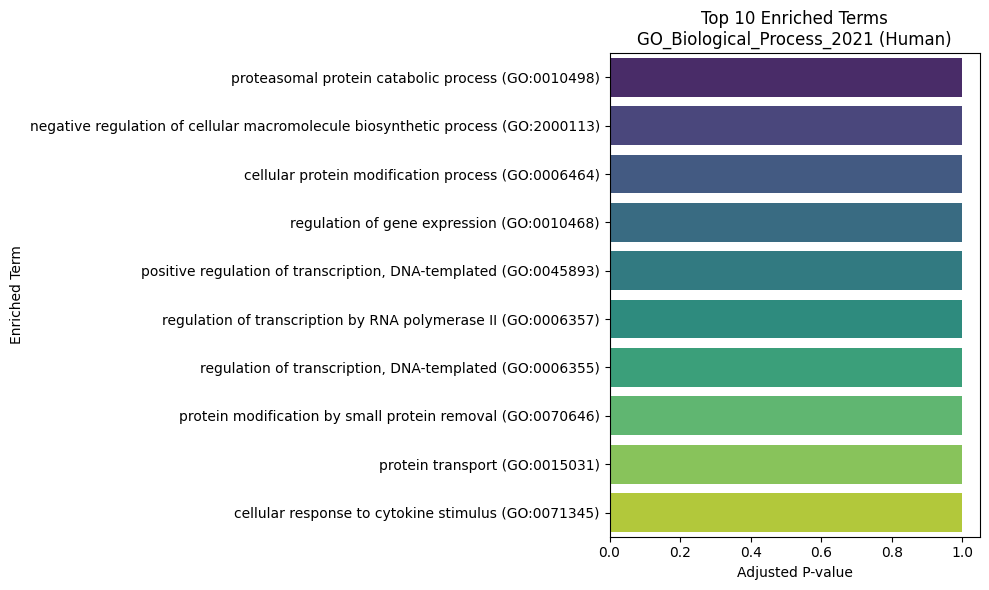

✅ Saved: enrichment_barplot_GO_Biological_Process_2021.png

🔎 Running enrichment for GO_Cellular_Component_2021...


2025-09-25 17:17:48,677 [INFO] Run: GO_Cellular_Component_2021 
2025-09-25 17:17:50,703 [INFO] Done.
/tmp/ipython-input-1441417504.py:118: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




✅ Saved: enrichment_results_GO_Cellular_Component_2021.csv (218 terms)


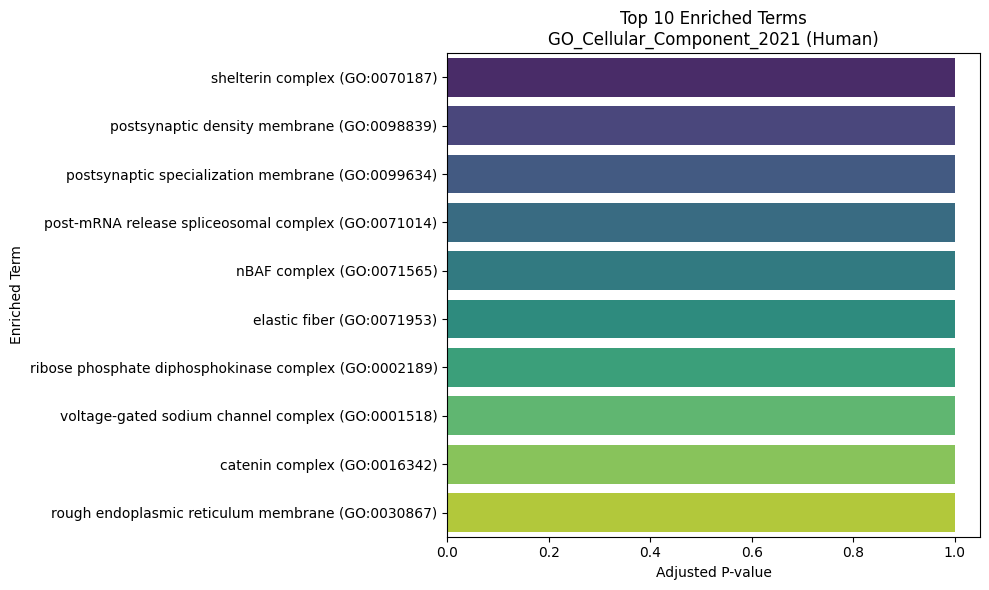

✅ Saved: enrichment_barplot_GO_Cellular_Component_2021.png

🔎 Running enrichment for GO_Molecular_Function_2021...


2025-09-25 17:17:51,730 [INFO] Run: GO_Molecular_Function_2021 
2025-09-25 17:17:53,732 [INFO] Done.
/tmp/ipython-input-1441417504.py:118: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




✅ Saved: enrichment_results_GO_Molecular_Function_2021.csv (407 terms)


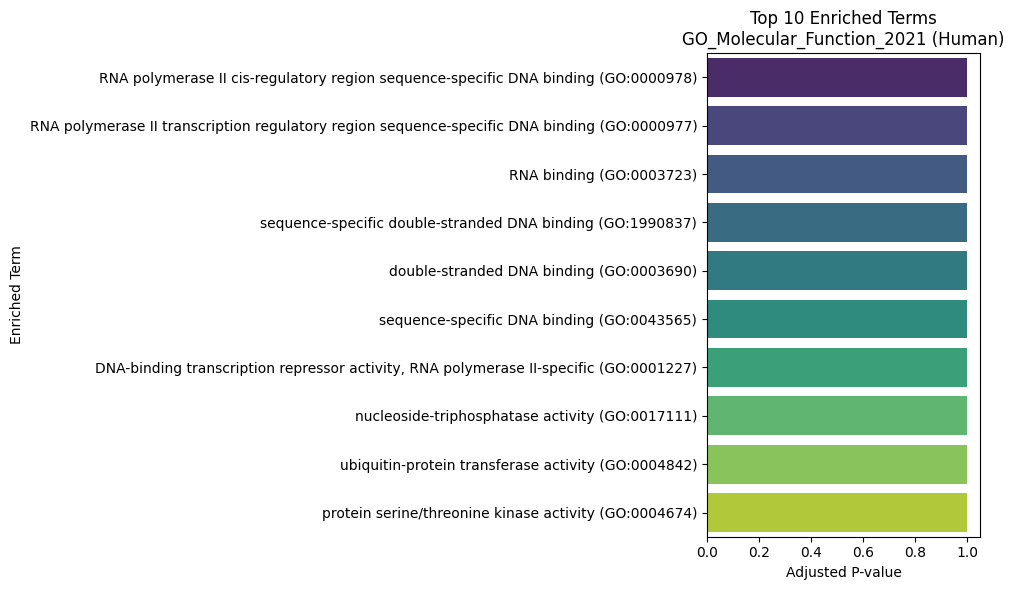

✅ Saved: enrichment_barplot_GO_Molecular_Function_2021.png

🔎 Running enrichment for KEGG_2021_Human...


2025-09-25 17:17:54,828 [INFO] Run: KEGG_2021_Human 
2025-09-25 17:17:56,798 [INFO] Done.
/tmp/ipython-input-1441417504.py:118: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




✅ Saved: enrichment_results_KEGG_2021_Human.csv (230 terms)


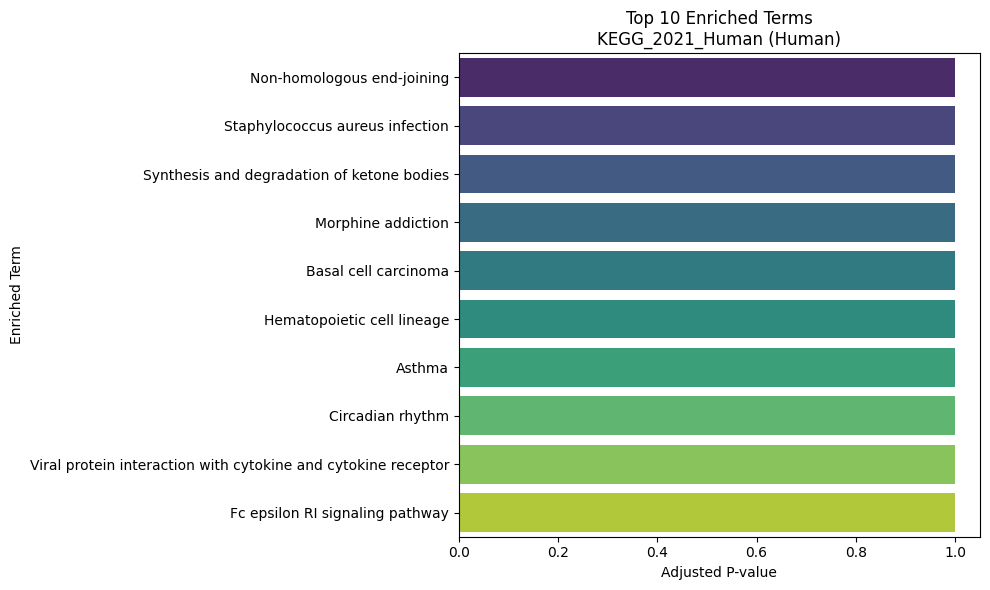

✅ Saved: enrichment_barplot_KEGG_2021_Human.png

🔎 Running enrichment for Reactome_2022...


2025-09-25 17:17:57,802 [INFO] Run: Reactome_2022 
2025-09-25 17:17:59,802 [INFO] Done.
/tmp/ipython-input-1441417504.py:118: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




✅ Saved: enrichment_results_Reactome_2022.csv (778 terms)


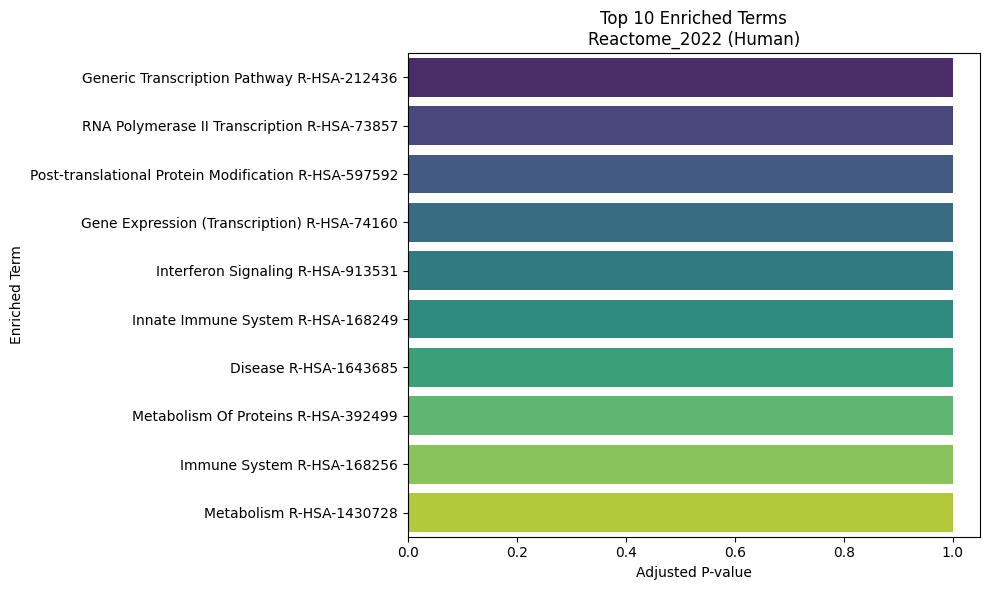

✅ Saved: enrichment_barplot_Reactome_2022.png


In [40]:
# =============================
# Functional Enrichment with Probe → Gene Symbol Mapping
# Auto Organism + Multi-Gene Set Visualization
# =============================

from gseapy import get_library_name

if not sig_df.empty:
    print("Preparing gene list for enrichment...")

    # ----------------------------
    # Step 1: Detect organism
    # ----------------------------
    try:
        if "organism_ch1" in gse.metadata:
            organism_raw = gse.metadata["organism_ch1"][0]
        else:
            organism_raw = "Human"
        print(f"Detected organism: {organism_raw}")
    except Exception as e:
        print(f"⚠️ Could not detect organism: {e}")
        organism_raw = "Human"

    organism_map = {
        "Homo sapiens": "Human",
        "human": "Human",
        "Mus musculus": "Mouse",
        "mouse": "Mouse",
        "Rattus norvegicus": "Rat",
        "rat": "Rat"
    }
    organism = organism_map.get(organism_raw, "Human")
    print(f"Using Enrichr organism: {organism}")

    # ----------------------------
    # Step 2: Probe → Gene Symbol mapping
    # ----------------------------
    sig_genes = []
    try:
        platform_id = list(gse.gpls.keys())[0]
        platform_geo = GEOparse.get_GEO(geo=platform_id, destdir=".")
        platform_annot = platform_geo.table

        candidate_cols = [c for c in platform_annot.columns if "symbol" in c.lower()]

        if "ID" in platform_annot.columns and candidate_cols:
            gene_col = candidate_cols[0]
            print(f"Using annotation column: {gene_col}")

            probe_to_symbol = platform_annot.set_index("ID")[gene_col].dropna().to_dict()
            sig_df["Gene_Symbol"] = sig_df["probid"].map(probe_to_symbol)
            sig_genes = sig_df["Gene_Symbol"].dropna().astype(str).tolist()

            print(f"✅ Mapped {len(sig_genes)} probes to gene symbols.")
        else:
            print("⚠️ No gene symbol column found, using probe IDs instead.")
            sig_genes = sig_df["probid"].dropna().astype(str).tolist()

    except Exception as e:
        print(f"⚠️ Mapping failed: {e}")
        sig_genes = sig_df["probid"].dropna().astype(str).tolist()

    # ----------------------------
    # Step 3: Choose gene sets interactively
    # ----------------------------
    if sig_genes:
        print("\nFetching available gene sets from Enrichr...")
        all_libraries = get_library_name(organism=organism)
        print(f"Total available libraries for {organism}: {len(all_libraries)}")

        default_sets = [
            "GO_Biological_Process_2021",
            "GO_Cellular_Component_2021",
            "GO_Molecular_Function_2021",
            "KEGG_2021_Human",
            "Reactome_2022",
            "WikiPathways_2023_Human"
        ]
        for ds in default_sets:
            if ds in all_libraries:
                print(f" - {ds}")

        chosen_sets = input("\nEnter gene sets to use (comma-separated) or press Enter for defaults: ").strip()
        if chosen_sets:
            gene_sets = [s.strip() for s in chosen_sets.split(",")]
        else:
            gene_sets = [s for s in default_sets if s in all_libraries]

        print(f"Using gene sets: {gene_sets}")

        # ----------------------------
        # Step 4: Run enrichment per gene set
        # ----------------------------
        for gs in gene_sets:
            print(f"\n🔎 Running enrichment for {gs}...")

            enr = gp.enrichr(
                gene_list=sig_genes,
                gene_sets=[gs],   # run per library
                organism=organism,
                outdir=None,
                cutoff=1.0,
                verbose=True
            )

            if hasattr(enr, "res2d") and not enr.res2d.empty:
                enrichment_df = enr.res2d.copy()
                fname_base = gs.replace(" ", "_").replace("-", "_")

                enrichment_df.to_csv(f"enrichment_results_{fname_base}.csv", index=False)
                print(f"✅ Saved: enrichment_results_{fname_base}.csv ({enrichment_df.shape[0]} terms)")

                # Visualization
                top_n = 10
                top_terms = enrichment_df.sort_values("Adjusted P-value").head(top_n)

                plt.figure(figsize=(10, 6))
                sns.barplot(
                    x="Adjusted P-value",
                    y="Term",
                    data=top_terms.sort_values("Adjusted P-value", ascending=False),
                    palette="viridis"
                )
                plt.title(f"Top {top_n} Enriched Terms\n{gs} ({organism})")
                plt.xlabel("Adjusted P-value")
                plt.ylabel("Enriched Term")
                plt.tight_layout()
                plt.savefig(f"enrichment_barplot_{fname_base}.png", dpi=300)
                plt.show()
                print(f"✅ Saved: enrichment_barplot_{fname_base}.png")

            else:
                print(f"⚠️ No enrichment terms found for {gs}")

    else:
        print("⚠️ No valid genes for enrichment analysis.")
else:
    print("⚠️ No significant DEGs available for enrichment analysis.")


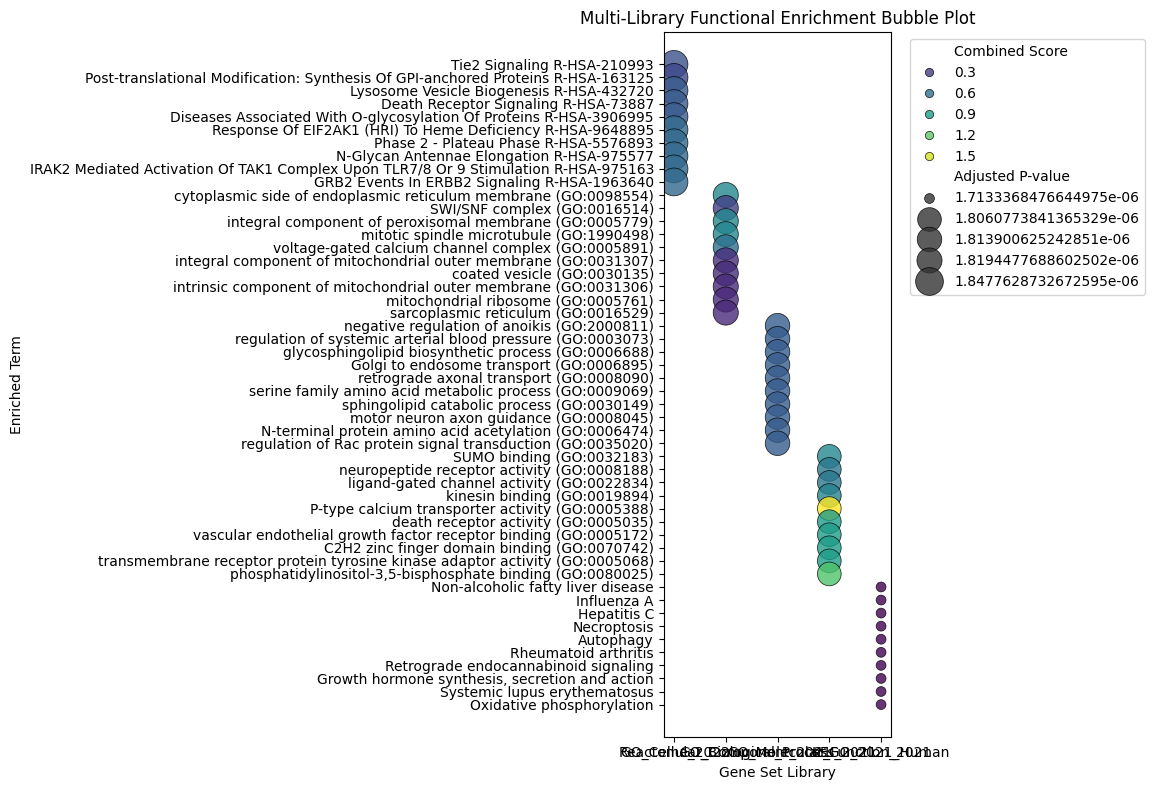

✅ Saved: enrichment_bubbleplot_all.png


In [41]:
# =====================================
# Combined Bubble Plot of Enrichment Results
# =====================================

all_results = []  # collect results across libraries

for gs in gene_sets:
    fname_base = gs.replace(" ", "_").replace("-", "_")
    try:
        df = pd.read_csv(f"enrichment_results_{fname_base}.csv")
        df["Library"] = gs
        all_results.append(df)
    except FileNotFoundError:
        print(f"⚠️ Skipping {gs}, results file not found.")

if all_results:
    combined_df = pd.concat(all_results, ignore_index=True)

    # Keep top 10 per library
    top_combined = (
        combined_df
        .sort_values("Adjusted P-value")
        .groupby("Library")
        .head(10)
    )

    # Transform for bubble plot
    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        data=top_combined,
        x="Library",
        y="Term",
        size=-np.log10(top_combined["Adjusted P-value"]),
        hue="Combined Score",
        palette="viridis",
        sizes=(50, 400),
        alpha=0.8,
        edgecolor="k"
    )

    plt.title("Multi-Library Functional Enrichment Bubble Plot")
    plt.xlabel("Gene Set Library")
    plt.ylabel("Enriched Term")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.savefig("enrichment_bubbleplot_all.png", dpi=300)
    plt.show()

    print("✅ Saved: enrichment_bubbleplot_all.png")
else:
    print("⚠️ No enrichment results found for bubble plot.")


In [42]:
# =====================================
# Interactive Bubble Plot (Plotly)
# =====================================
import plotly.express as px

all_results = []

for gs in gene_sets:
    fname_base = gs.replace(" ", "_").replace("-", "_")
    try:
        df = pd.read_csv(f"enrichment_results_{fname_base}.csv")
        df["Library"] = gs
        all_results.append(df)
    except FileNotFoundError:
        print(f"⚠️ Skipping {gs}, results file not found.")

if all_results:
    combined_df = pd.concat(all_results, ignore_index=True)

    # Keep top 10 terms per library
    top_combined = (
        combined_df
        .sort_values("Adjusted P-value")
        .groupby("Library")
        .head(10)
    )

    # Add -log10(Adjusted P-value) for scaling
    top_combined["-log10FDR"] = -np.log10(top_combined["Adjusted P-value"] + 1e-300)

    # Plotly bubble plot
    fig = px.scatter(
        top_combined,
        x="Library",
        y="Term",
        size="-log10FDR",  # bubble size = significance
        color="Combined Score",  # bubble color
        hover_data={
            "Library": True,
            "Term": True,
            "Adjusted P-value": True,
            "Combined Score": True,
            "-log10FDR": False
        },
        color_continuous_scale="Viridis",
        size_max=40,
        title="Interactive Multi-Library Enrichment Bubble Plot"
    )

    fig.update_layout(
        xaxis_title="Gene Set Library",
        yaxis_title="Enriched Term",
        legend_title="Combined Score",
        width=1100,
        height=700
    )

    fig.show()
else:
    print("⚠️ No enrichment results found for Plotly bubble plot.")
